# Báo cáo BTL môn Học máy
- Mã lớp: 2021II_INT3405_20 (GV: Trần Quốc Long)
- Sinh viên: Trần Tuấn Anh
- MSSV: 18020149

# Mô tả bài toán

Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi và kết nối với những người khác, những người đóng góp thông tin chi tiết độc đáo và câu trả lời chất lượng. Một thách thức quan trọng là loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích.

Bài toán đặt ra là phân loại câu hỏi trên quora xem đâu là chân thành hay thiếu chân thành.
- Input: Câu hỏi dưới dạng văn bản
- Output: 0/1 (Yes/No)

# Nội dung bài báo cáo

1. Khảo sát dữ liệu
2. Xử lý dữ liệu
3. Chuẩn bị mô hình huấn luyện
4. Huấn luyện và dự đoán
5. Thử nghiệm và cải thiện
6. Submit test

**Import các module cần thiết**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import re
import spacy

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.initializers import Constant
from keras.utils import plot_model
from keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.datasets import make_classification

from tqdm.notebook import tqdm
from IPython.core.display import display, HTML
tqdm().pandas()

pd_ctx = pd.option_context('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

0it [00:00, ?it/s]

# 1. Khảo sát dữ liệu

In [4]:
# đọc file dữ liệu để train
TRAIN_FILE = '/kaggle/input/quora-insincere-questions-classification/train.csv'
TEST_FILE = '/kaggle/input/quora-insincere-questions-classification/test.csv'
df = pd.read_csv(TRAIN_FILE)
df.info()

test_df = pd.read_csv(TEST_FILE)
with pd_ctx:
    print("Sincere question")
    display(df[df['target'] == 0].head())
    print("Insincere question")
    display(df[df['target'] == 1].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
Sincere question


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


Insincere question


,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Repub...,1
114,00052793eaa287aff1e1,"I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and ...",1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


**Kích thước train.csv:**
* Số dòng: 1.31 millions
* Số cột: 3

**Data field**
+ `qid`: mã số của câu hỏi (question identifier)
+ `quesntion_text`: nội dung của câu hỏi cần phân loại (type: text)
+ `target`: nhãn của câu hỏi, câu chứa nội dung toxic có nhãn là 1, ngược lại là 0 (type: int)

Không có dữ liệu nào bất thường (missing, null)

  0%|          | 0/1306122 [00:00<?, ?it/s]

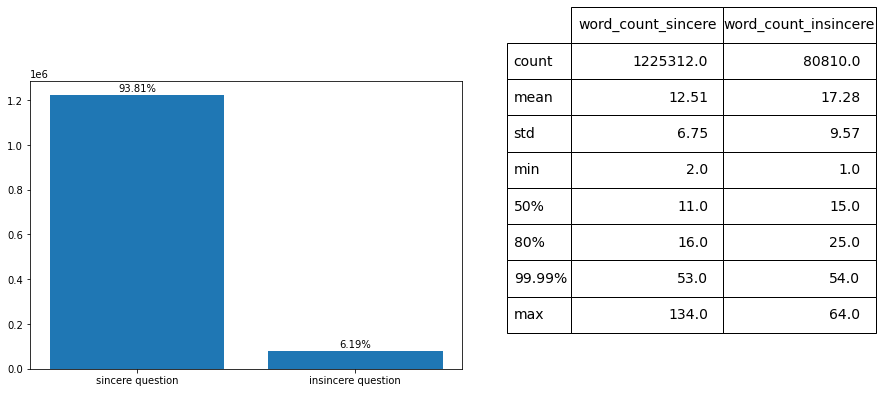

In [5]:
df['word_count']= df.question_text.progress_apply(lambda x: len(x.split()))
data_neg = df[df['target']==0]
data_pos = df[df['target']==1]
statistic = pd.merge(
    data_neg[['word_count']].describe(percentiles=[.8, .9999]), 
    data_pos[['word_count']].describe(percentiles=[.8, .9999]), 
    left_index=True, right_index=True, suffixes=('_sincere', '_insincere')
)
colLabels = statistic.columns
cellText = statistic.round(2).values
rowLabels = statistic.index

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0] = fig.add_axes([0,0,1,1])
axes[0].bar(['sincere question', 'insincere question'], df.target.value_counts())
for p in axes[0].patches:
    width = p.get_width()
    height = p.get_height()
    percent = height / len(df)
    x, y = p.get_xy() 
    axes[0].annotate(f'{percent:.2%}', (x + width/2, y + height + 0.01*len(df)), ha='center')
axes[1].axis('off')
mpl_table = axes[1].table(cellText = cellText, colLabels=colLabels, rowLabels = rowLabels, bbox=[2, 0, 2, 1.5], )
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(14)

**Nhận xét về phân lớp dữ liệu**

Dựa vào biểu đồ trên, ta nhận thấy dữ liệu được chia thành 2 class: 0 (sincere question) và 1 (insincere question)

- class 0 : 1225312 dữ liệu chiếm 93.81%
- class 1 : 80810 dữ liệu chiếm 6.19%

=> Bộ dữ liệu để đào tạo bị mất cân bằng (kết quả negative gấp 15 lần positive)

Tỉ lệ dữ liệu 15:1 thường sẽ dẫn đến ngộ nhận chất lượng mô hình. Khi đó thước đo đánh giá mô hình là độ chính xác (accuracy) có thể đạt được rất cao mà không cần tới mô hình. Ví dụ, một dự báo ngẫu nhiên đưa ra tất cả đều là nhóm đa số thì độ chính xác đã đạt được là 93%. Do đó không nên lựa chọn độ chính xác làm chỉ số đánh giá mô hình để tránh lạc quan sai lầm về chất lượng.

=> Trong phần báo cáo này, mình sẽ sử dụng chỉ số `F1_score` để đánh giá mô hình.

**Nói qua về [F1 score](https://en.wikipedia.org/wiki/F-score):**

`F1_score` là trung bình điều hòa giữa `precision` (độ chính xác) và `recall` (độ bao phủ)

Precision: trong tập tìm được thì bao nhiêu cái (phân loại) đúng.

Recall: trong số các tồn tại, tìm ra được bao nhiêu cái (phân loại).




**Nhận xét độ dài của các câu trong bộ dữ liệu**

- Câu chân thành
        Độ dài chung bình khoảng 12,5 từ. Câu dài nhất là 134 từ.
        80% số câu có ít hơn hoặc bằng 15 từ.
        Hầu như đều có dưới 53 từ.
- Câu không chân thành 
        Độ dài trung bình là 17.3 từ. Câu dài nhát là 64 từ.
        80% số câu ít hơn hoặc bằng 25 từ.
        Hầu như đều có dưới 54 từ.

=> Câu không chân thành có xu hướng dài hơn câu chân thành. Và độ dài của các câu chủ yếu nhỏ hơn 60 ký tự (giá trị này sẽ được dùng sau này)

### Khảo sát các từ xuất hiện nhiều trong từ phân lớp

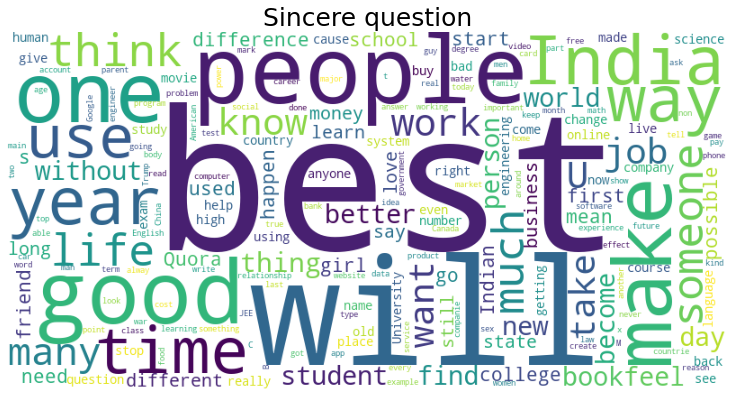

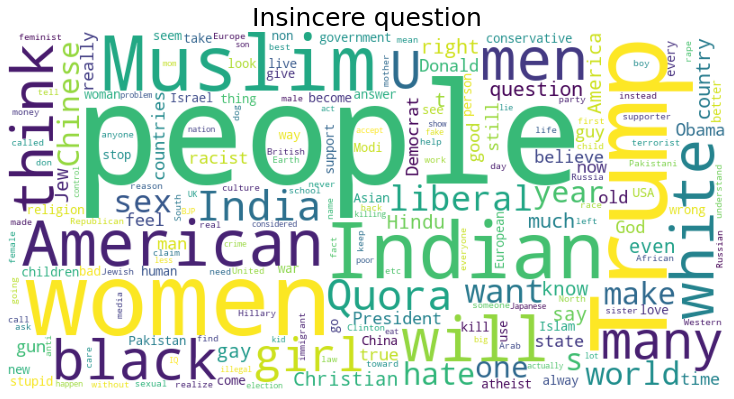

In [6]:
def cloud(docs, title):
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color="white").generate(" ".join(docs))
    fig = plt.figure(figsize=(10,7), facecolor='w')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=25,color='k')
    plt.tight_layout(pad=0)
    plt.show()
cloud(data_neg.question_text, "Sincere question")
cloud(data_pos.question_text, "Insincere question")

**Nhận xét**

- Word Cloud là một kỹ thuật trực quan hóa dữ liệu được sử dụng để biểu diễn dữ liệu văn bản, trong đó kích thước của mỗi từ cho biết tần suất hoặc tầm quan trọng của nó.
- 2 word cloud khá tương tự nhau (khi so sánh về các từ nổi bật)
- Các danh từ riêng xuất hiện nhiều hơn ở câu không chân thành


**Thống kê**

In [7]:
def statistic(df):
    stats = pd.DataFrame();
    stats['question_text'] = df['question_text']
    stats['sp_char_words'] = stats['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
    stats['num_capital'] = stats['question_text'].progress_map(lambda x: len([c for c in str(x) if c.isupper()]))
    stats['num_numerics'] = stats['question_text'].progress_map(lambda x: sum(c.isdigit() for c in x))
    stats['num_stopwords'] = stats['question_text'].progress_map(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
    return stats
# df_stat = statistic(df)
# df_stat[['sp_char_words','num_capital', 'num_numerics', 'num_stopwords']].describe()

Nhận xét: Nhìn chung, dữ liệu dạng text chứa khá nhiều yêu tố gây nhiễu (kí tự đặc biệt, kí tự số, chữ hoa chữ thường)

Vì vậy ta cần có bước xử lý các ký tự đặc biệt, stopword (nếu cần)



# 2. Xử lý dữ liệu

Sau khi đánh giá ta thấy dữ liệu còn khá phức tạp và nhiều nhiễu. Để đơn giản hoá dữ liệu ta có thể thực hiện một số bước sau:
- Loại bỏ các công thức toán học, đường dẫn
- Chuẩn hóa các từ viết tắt thành dạng đầy đủ của nó
- Sửa lỗi một số từ đặc biệt, hoặc bị sai chính tả 
- Xóa bỏ các ký tự đặc biệt (chỉ giữ lại số và chữ)

Riêng về stopword, em nhân thấy rằng sau khi bỏ thì khả năng phân loại của mô hình bị giảm xuống, nên phần xử lý dữ liệu em sẽ để nguyên stopword

In [8]:
# dữ liệu để huấn luyện
train = df.sample(frac = 1,random_state=123).reset_index(drop=True) # shuffle dữ liệu

# Để demo nhanh, ở đây mình lấy ra 100 mẫu dữ liệu sample
sample = train.sample(n=100, random_state=123)
with pd_ctx:
    display(sample)

,qid,question_text,target,word_count
677319,cb304a4facdd58b51c83,What are the difference between 'critical review of a movie' and ' citical review a book'?,0,16
802133,7e4d6540ebe0b9b50228,Why would an intelligent girl interested in an average guy?,0,10
357211,3b133b7c626528f9e27d,Will a 1460 in SAT and 1560 in sat subject test witha good essay give me admission at Caltech?,0,19
165764,8fda4bfd14deeea0cd61,How do doctors who perform euthanasia on their patients harmonise their practice with their oath...,0,19
441097,e34b913ea70d9105f679,How was the cosmic microwave background discovered or made?,0,9
...,...,...,...,...
585732,29109fb3457408af94fb,How do I deal with a cheater if I depend on him financially?,0,13
823158,9433706c914b1d3a3d7a,How do I stay focused for long time on studies?,0,10
688032,c9f2c2c6e825f15a9655,Did Leia appreciate the warmth emitted by Jabba's body at night?,0,11
1256372,114249d6bea154f99abb,Can an international student get an admission in Canada while studying in Norway?,0,13


## a. Cleaning data

**`clean_tag()`:** hàm này sẽ loại bỏ các biểu thức toán học, thay thế chúng bằng 'MATH EQUATION' và thay thế các đường liên kết bằng 'URL'. Bởi vì các biểu thức toán học và các đường link thường không mang nhiều ý nghĩa, không những vậy nó còn có thể gây ra nhiễu.

**`contraction_fix()`:** Chuyển những từ viết tắt thành hoàn chỉnh để tránh xảy ra sự hiểu lầm.

**`misspell_fix()`:** Do dữ liệu được thu thập trên Qoura, nên không thể tránh được việc bị sai chính tả. Nên việc sửa các từ bị sai chính tả là cần thiết, mục đích cũng giống với sửa các từ viết tắt. Nhưng ta không thể biết được hết các khả năng sai chính tả được, nên mình sẽ chỉ sửa những từ sai chính tả thường gặp, hoặc thay thế một số từ tối nghĩa thành từ đồng nghĩa với nó.

In [9]:
# Làm sạch câu
contractions= {"i'm": 'i am',"i'm'a": 'i am about to',"i'm'o": 'i am going to',"i've": 'i have',"i'll": 'i will',"i'll've": 'i will have',"i'd": 'i would',"i'd've": 'i would have',"Whatcha": 'What are you',"amn't": 'am not',"ain't": 'are not',"aren't": 'are not',"'cause": 'because',"can't": 'can not',"can't've": 'can not have',"could've": 'could have',"couldn't": 'could not',"couldn't've": 'could not have',"daren't": 'dare not',"daresn't": 'dare not',"dasn't": 'dare not',"didn't": 'did not','didn’t': 'did not',"don't": 'do not','don’t': 'do not',"doesn't": 'does not',"e'er": 'ever',"everyone's": 'everyone is',"finna": 'fixing to',"gimme": 'give me',"gon't": 'go not',"gonna": 'going to',"gotta": 'got to',"hadn't": 'had not',"hadn't've": 'had not have',"hasn't": 'has not',"haven't": 'have not',"he've": 'he have',"he's": 'he is',"he'll": 'he will',"he'll've": 'he will have',"he'd": 'he would',"he'd've": 'he would have',"here's": 'here is',"how're": 'how are',"how'd": 'how did',"how'd'y": 'how do you',"how's": 'how is',"how'll": 'how will',"isn't": 'is not',"it's": 'it is',"'tis": 'it is',"'twas": 'it was',"it'll": 'it will',"it'll've": 'it will have',"it'd": 'it would',"it'd've": 'it would have',"kinda": 'kind of',"let's": 'let us',"luv": 'love',"ma'am": 'madam',"may've": 'may have',"mayn't": 'may not',"might've": 'might have',"mightn't": 'might not',"mightn't've": 'might not have',"must've": 'must have',"mustn't": 'must not',"mustn't've": 'must not have',"needn't": 'need not',"needn't've": 'need not have',"ne'er": 'never',"o'": 'of',"o'clock": 'of the clock',"ol'": 'old',"oughtn't": 'ought not',"oughtn't've": 'ought not have',"o'er": 'over',"shan't": 'shall not',"sha'n't": 'shall not',"shalln't": 'shall not',"shan't've": 'shall not have',"she's": 'she is',"she'll": 'she will',"she'd": 'she would',"she'd've": 'she would have',"should've": 'should have',"shouldn't": 'should not',"shouldn't've": 'should not have',"so've": 'so have',"so's": 'so is',"somebody's": 'somebody is',"someone's": 'someone is',"something's": 'something is',"sux": 'sucks',"that're": 'that are',"that's": 'that is',"that'll": 'that will',"that'd": 'that would',"that'd've": 'that would have',"em": 'them',"there're": 'there are',"there's": 'there is',"there'll": 'there will',"there'd": 'there would',"there'd've": 'there would have',"these're": 'these are',"they're": 'they are',"they've": 'they have',"they'll": 'they will',"they'll've": 'they will have',"they'd": 'they would',"they'd've": 'they would have',"this's": 'this is',"those're": 'those are',"to've": 'to have',"wanna": 'want to',"wasn't": 'was not',"we're": 'we are',"we've": 'we have',"we'll": 'we will',"we'll've": 'we will have',"we'd": 'we would',"we'd've": 'we would have',"weren't": 'were not',"what're": 'what are',"what'd": 'what did',"what've": 'what have',"what's": 'what is',"what'll": 'what will',"what'll've": 'what will have',"when've": 'when have',"when's": 'when is',"where're": 'where are',"where'd": 'where did',"where've": 'where have',"where's": 'where is',"which's": 'which is',"who're": 'who are',"who've": 'who have',"who's": 'who is',"who'll": 'who will',"who'll've": 'who will have',"who'd": 'who would',"who'd've": 'who would have',"why're": 'why are',"why'd": 'why did',"why've": 'why have',"why's": 'why is',"will've": 'will have',"won't": 'will not',"won't've": 'will not have',"would've": 'would have',"wouldn't": 'would not',"wouldn't've": 'would not have',"y'all": 'you all',"y'all're": 'you all are',"y'all've": 'you all have',"y'all'd": 'you all would',"y'all'd've": 'you all would have',"you're": 'you are',"you've": 'you have',"you'll've": 'you shall have',"you'll": 'you will',"you'd": 'you would',"you'd've": 'you would have','jan.': 'january','feb.': 'february','mar.': 'march','apr.': 'april','jun.': 'june','jul.': 'july','aug.': 'august','sep.': 'september','oct.': 'october','nov.': 'november','dec.': 'december','I’m': 'I am','I’m’a': 'I am about to','I’m’o': 'I am going to','I’ve': 'I have','I’ll': 'I will','I’ll’ve': 'I will have','I’d': 'I would','I’d’ve': 'I would have','amn’t': 'am not','ain’t': 'are not','aren’t': 'are not','’cause': 'because','can’t': 'can not','can’t’ve': 'can not have','could’ve': 'could have','couldn’t': 'could not','couldn’t’ve': 'could not have','daren’t': 'dare not','daresn’t': 'dare not','dasn’t': 'dare not','doesn’t': 'does not','e’er': 'ever','everyone’s': 'everyone is','gon’t': 'go not','hadn’t': 'had not','hadn’t’ve': 'had not have','hasn’t': 'has not','haven’t': 'have not','he’ve': 'he have','he’s': 'he is','he’ll': 'he will','he’ll’ve': 'he will have','he’d': 'he would','he’d’ve': 'he would have','here’s': 'here is','how’re': 'how are','how’d': 'how did','how’d’y': 'how do you','how’s': 'how is','how’ll': 'how will','isn’t': 'is not','it’s': 'it is','’tis': 'it is','’twas': 'it was','it’ll': 'it will','it’ll’ve': 'it will have','it’d': 'it would','it’d’ve': 'it would have','let’s': 'let us','ma’am': 'madam','may’ve': 'may have','mayn’t': 'may not','might’ve': 'might have','mightn’t': 'might not','mightn’t’ve': 'might not have','must’ve': 'must have','mustn’t': 'must not','mustn’t’ve': 'must not have','needn’t': 'need not','needn’t’ve': 'need not have','ne’er': 'never','o’': 'of','o’clock': 'of the clock','ol’': 'old','oughtn’t': 'ought not','oughtn’t’ve': 'ought not have','o’er': 'over','shan’t': 'shall not','sha’n’t': 'shall not','shalln’t': 'shall not','shan’t’ve': 'shall not have','she’s': 'she is','she’ll': 'she will','she’d': 'she would','she’d’ve': 'she would have','should’ve': 'should have','shouldn’t': 'should not','shouldn’t’ve': 'should not have','so’ve': 'so have','so’s': 'so is','somebody’s': 'somebody is','someone’s': 'someone is','something’s': 'something is','that’re': 'that are','that’s': 'that is','that’ll': 'that will','that’d': 'that would','that’d’ve': 'that would have','there’re': 'there are','there’s': 'there is','there’ll': 'there will','there’d': 'there would','there’d’ve': 'there would have','these’re': 'these are','they’re': 'they are','they’ve': 'they have','they’ll': 'they will','they’ll’ve': 'they will have','they’d': 'they would','they’d’ve': 'they would have','this’s': 'this is','those’re': 'those are','to’ve': 'to have','wasn’t': 'was not','we’re': 'we are','we’ve': 'we have','we’ll': 'we will','we’ll’ve': 'we will have','we’d': 'we would','we’d’ve': 'we would have','weren’t': 'were not','what’re': 'what are','what’d': 'what did','what’ve': 'what have','what’s': 'what is','what’ll': 'what will','what’ll’ve': 'what will have','when’ve': 'when have','when’s': 'when is','where’re': 'where are','where’d': 'where did','where’ve': 'where have','where’s': 'where is','which’s': 'which is','who’re': 'who are','who’ve': 'who have','who’s': 'who is','who’ll': 'who will','who’ll’ve': 'who will have','who’d': 'who would','who’d’ve': 'who would have','why’re': 'why are','why’d': 'why did','why’ve': 'why have','why’s': 'why is','will’ve': 'will have','won’t': 'will not','won’t’ve': 'will not have','would’ve': 'would have','wouldn’t': 'would not','wouldn’t’ve': 'would not have','y’all': 'you all','y’all’re': 'you all are','y’all’ve': 'you all have','y’all’d': 'you all would','y’all’d’ve': 'you all would have','you’re': 'you are','you’ve': 'you have','you’ll’ve': 'you shall have','you’ll': 'you will','you’d': 'you would','you’d’ve': 'you would have'}
missing_spell = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization','electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin','lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency','simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized','iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime','cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp','undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp','reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone','dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu','openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp','empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money','fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation','trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath','bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized','brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language','splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu','weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency'}

def clean_tag(x):
    if '[math]' in x:
        x = re.sub('\[math\].*?math\]', 'math equation', x) #replacing with [MATH EQUATION]
    if 'http' in x or 'www' in x:
        x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'url', x) #replacing with [url]
    return x

def contraction_fix(word):
    try:
        a=contractions[word]
    except KeyError:
        a=word
    return a

def misspell_fix(word):
    try:
        a=missing_spell[word]
    except KeyError:
        a=word
    return a


def clean_text(text):
    text = clean_tag(text) # thay thế các tag thành từ cố định
    text = " ".join([contraction_fix(w) for w in text.split()]) # sửa từ viết tắt
    text = " ".join([misspell_fix(w) for w in text.split()]) # sửa từ viết sai chính tả
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) # Loại bỏ các ký tự không phải chữ và số
#     text = text.lower()
    return text

def apply_clean_text(question_text):
    tmp = pd.DataFrame()
    tmp['question_text'] = question_text;
    tmp['clean'] = tmp.question_text.progress_map(clean_text)
    with pd_ctx:
        display(tmp)
    return tmp['clean']
        
sample['clean'] = apply_clean_text(sample.question_text)

  0%|          | 0/100 [00:00<?, ?it/s]

,question_text,clean
677319,What are the difference between 'critical review of a movie' and ' citical review a book'?,What are the difference between critical review of a movie and citical review a book
802133,Why would an intelligent girl interested in an average guy?,Why would an intelligent girl interested in an average guy
357211,Will a 1460 in SAT and 1560 in sat subject test witha good essay give me admission at Caltech?,Will a 1460 in SAT and 1560 in sat subject test witha good essay give me admission at Caltech
165764,How do doctors who perform euthanasia on their patients harmonise their practice with their oath...,How do doctors who perform euthanasia on their patients harmonise their practice with their oath...
441097,How was the cosmic microwave background discovered or made?,How was the cosmic microwave background discovered or made
...,...,...
585732,How do I deal with a cheater if I depend on him financially?,How do I deal with a cheater if I depend on him financially
823158,How do I stay focused for long time on studies?,How do I stay focused for long time on studies
688032,Did Leia appreciate the warmth emitted by Jabba's body at night?,Did Leia appreciate the warmth emitted by Jabba s body at night
1256372,Can an international student get an admission in Canada while studying in Norway?,Can an international student get an admission in Canada while studying in Norway


## b. Mã hóa cột văn bản và chuyển đổi chúng thành vectơ

Do trường `question_text` là dạng văn bản, nên để dễ huấn luyện ta cần mã hóa để chuyển thành vecto của các số nguyên.

Tokenize là quá trình chia nhỏ văn bản thành các phần nhỏ hơn được gọi là token. Mỗi token sẽ biểu diễn 1 từ trong câu.

Module `keras.Tokenizer` sẽ giúp ta thực hiện viêc tokenize.

Bản chất nó sẽ duyệt qua các từ trong toàn bộ văn bản đê xây dựng lên 1 bộ từ điển. Sau đó sẽ sắp xếp các từ theo tần xuất xuất hiện của nó. Từ xuất hiện càng nhiều thì có index càng thấp. Sau đó sẽ sử dụng từ điển này để transform từng câu ở dạng text sang dạng sequence của số.

### Tạo từ điển

**`create_tokenizer()`:** sẽ tạo ra một từ điển từ tập văn bản truyền vào.

`OOV_TOKEN`: là token cho các từ mà không xuất hiện trong tập từ điển.

`word_index` là `dict` chứa ánh xạ của 1 từ sang index của nó

index càng nhỏ => tần suất xuất hiện càng nhiều

In [10]:
OOV_TOKEN = '<OOV>' # out of vocab token: thay thế các từ không có trong từ điển thành từ mà ta chọn
def create_tokenizer(docs):
    tokenizer = Tokenizer(oov_token=OOV_TOKEN)
    tokenizer.fit_on_texts(list(docs))
    print("Size of vocabulary: ", len(tokenizer.word_index))
    return tokenizer
tokenizer = create_tokenizer(sample['clean'])
print("20 từ đầu tiên trong từ điển:")
list(tokenizer.word_index.items())[:20]

Size of vocabulary:  630
20 từ đầu tiên trong từ điển:


[('<OOV>', 1),
 ('the', 2),
 ('what', 3),
 ('is', 4),
 ('a', 5),
 ('to', 6),
 ('and', 7),
 ('how', 8),
 ('of', 9),
 ('in', 10),
 ('for', 11),
 ('i', 12),
 ('do', 13),
 ('are', 14),
 ('it', 15),
 ('you', 16),
 ('why', 17),
 ('be', 18),
 ('s', 19),
 ('can', 20)]

### Sử dụng từ điển chuyển text thành sequence

Như đã nói ở bên trên, phần này sẽ chuyển các câu text thành các chuỗi số. Mục đích là để cho máy có thể hiểu và dễ dàng học được thôi.

In [11]:
word_sequences = tokenizer.texts_to_sequences(sample['clean'])
# Độ dài của mỗi chuỗi
print("Length of 20 first word_sequences:")
print(list(map(lambda x: len(x) ,word_sequences[:20])))

print("\n20 first word_sequences:")
for sequence in word_sequences[:20]:
    print(sequence)

Length of 20 first word_sequences:
[15, 10, 19, 19, 9, 16, 12, 25, 17, 14, 10, 17, 25, 13, 3, 11, 11, 27, 7, 5]

20 first word_sequences:
[3, 14, 2, 47, 29, 143, 76, 9, 5, 77, 7, 144, 76, 5, 145]
[17, 30, 22, 146, 78, 147, 10, 22, 48, 148]
[49, 5, 149, 10, 79, 7, 150, 10, 79, 151, 152, 153, 23, 154, 80, 35, 81, 24, 155]
[8, 13, 156, 157, 158, 159, 25, 50, 160, 161, 50, 162, 51, 50, 163, 52, 13, 164, 165]
[8, 36, 2, 166, 167, 168, 169, 37, 170]
[3, 4, 2, 171, 29, 172, 173, 7, 174, 175, 9, 22, 176, 11, 177, 82]
[178, 4, 2, 179, 180, 9, 181, 182, 183, 11, 5, 184]
[26, 185, 186, 36, 2, 187, 9, 188, 10, 189, 190, 83, 9, 191, 24, 2, 82, 9, 2, 192, 193, 84, 194, 195, 196]
[85, 42, 197, 198, 199, 200, 201, 11, 2, 52, 43, 7, 3, 36, 202, 9, 203]
[3, 4, 2, 47, 29, 2, 204, 205, 86, 7, 206, 87, 207, 86]
[3, 4, 2, 208, 29, 27, 209, 7, 27, 210]
[14, 211, 212, 213, 6, 18, 214, 215, 88, 3, 14, 2, 38, 89, 6, 13, 15]
[20, 16, 80, 53, 216, 11, 90, 217, 54, 218, 91, 219, 31, 54, 220, 11, 2, 52, 43, 8, 20, 

Dễ dàng thấy độ dài của mỗi chuỗi không bằng nhau (chuỗi dài, chuỗi ngắn) => sẽ gây khó khắn cho quá trình huấn luyện mô hình.

Ta chuẩn hóa tất cả các input về cùng một độ dài cố định bằng ký thuật padding và truncating 

- `padding`: nếu chuỗi bị ngắn thì thực hiện padding bằng các thêm 0 vào đăng sau chuỗi.
    
- `truncating`: nếu chuỗi bị dài thì ta làm ngắn bằng cách bỏ đi phần dư ra ở cuối chuỗi.

Về phần padding và truncating ta sẽ làm các chuỗi sẽ có cùng một độ dài cố đinh, nhưng bao nhiêu thì hợp lý ?

Nhớ lại phần thống kê bên trên, ta thấy rằng có 99,99% dữ liệu có dưới 54 từ. (0.01% còn lại tương ứng với khoảng 100 bản ghi)

Để an toàn thì mình sẽ chọn chiều dài tối đa là 60 => đảm bảo không ảnh hưởng đến quá trình trainning.



In [12]:
MAX_SENTENCE_LENGTH = 60 # Độ dài tối đa của chuỗi
PADDING_TYPE = 'post' # kiểu padding, post = cuối chuỗi
TRUNCATE_TYPE = 'post'# kiểu truncating, post = cuối chuỗi
def create_sequence(tokenizer, docs):
    word_sequeces = tokenizer.texts_to_sequences(docs)
    padded_word_sequences = pad_sequences(word_sequeces, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
    return padded_word_sequences
padded_sequences = create_sequence(tokenizer, sample['clean'])

    
# Độ dài của mỗi chuỗi
print("Kích thước mảng:",padded_sequences.shape)

print("Length of 20 first word_sequences:")
print(list(map(lambda x: len(x) ,padded_sequences[:20])))

print("\n10 first word_sequences:")
for sequence in padded_sequences[:10]:
    print(sequence)


Kích thước mảng: (100, 60)
Length of 20 first word_sequences:
[60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]

10 first word_sequences:
[  3  14   2  47  29 143  76   9   5  77   7 144  76   5 145   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
[ 17  30  22 146  78 147  10  22  48 148   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
[ 49   5 149  10  79   7 150  10  79 151 152 153  23 154  80  35  81  24
 155   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
[  8  13 156 157 158 159  25  50 160 161  50 162  51  50 163  52  13 164
 165   0   0   0   0   

Sau bước này, độ dài của tất cả các chuỗi đều bằng nhau (len = 60)
Về cơ bản thì phần tiền xứ lý dữ liệu đã xong.

**Áp dụng phần tiền xử lý cho dữ liệu**

In [13]:
# Thực hiện làm sạch cho dữ liêu huấn luyện và dữ liêu test để chuẩn bị qua quá trình train
trainY = train.target

print("Clean train question")
trainX_text = apply_clean_text(train.question_text)
print("Clean test question")
testX_text = apply_clean_text(test_df.question_text)

Clean train question


  0%|          | 0/1306122 [00:00<?, ?it/s]

,question_text,clean
0,Why do people tend to answer a question with a question?,Why do people tend to answer a question with a question
1,"If I add excess magnesium to aqueous potassium sulphate, will magnesium react with all the water...",If I add excess magnesium to aqueous potassium sulphate will magnesium react with all the water...
2,What is the least and max possible sentence for having a warrant for cutting off an ankle monito...,What is the least and max possible sentence for having a warrant for cutting off an ankle monito...
3,"What are the job options for intellectuals, physicists, science writers etc.?",What are the job options for intellectuals physicists science writers etc
4,How do I make it into St. Stephens College DU for BA (hons) in economics? I am from CBSE and a C...,How do I make it into St Stephens College DU for BA hons in economics I am from CBSE and a C...
...,...,...
1306117,How do I know if I'm an INFP or ENFP?,How do I know if I m an INFP or ENFP
1306118,"Are Cuckoos Calling, Silkworm and Career of Evil good books?",Are Cuckoos Calling Silkworm and Career of Evil good books
1306119,What is the South African Army about?,What is the South African Army about
1306120,How much scholarship we get in entrance test?,How much scholarship we get in entrance test


Clean test question


  0%|          | 0/375806 [00:00<?, ?it/s]

,question_text,clean
0,Why do so many women become so rude and arrogant when they get just a little bit of wealth and p...,Why do so many women become so rude and arrogant when they get just a little bit of wealth and p...
1,When should I apply for RV college of engineering and BMS college of engineering? Should I wait ...,When should I apply for RV college of engineering and BMS college of engineering Should I wait ...
2,What is it really like to be a nurse practitioner?,What is it really like to be a nurse practitioner
3,Who are entrepreneurs?,Who are entrepreneurs
4,Is education really making good people nowadays?,Is education really making good people nowadays
...,...,...
375801,How many countries listed in gold import in indua?,How many countries listed in gold import in indua
375802,Is there an alternative to dresses on formal parties?,Is there an alternative to dresses on formal parties
375803,Where I can find best friendship quotes in Telugu?,Where I can find best friendship quotes in Telugu
375804,What are the causes of refraction of light?,What are the causes of refraction of light


## Chia thành dữ liệu thành 2 tập train và valid

Chia dữ liêu train thành 2 tập có tỉ lệ 2 class bằng với ban đầu.
- 80% để huấn luyện
- 20% để xác thực 

In [14]:
# Chia thành tập train và validate
X_train, X_val, y_train, y_val = train_test_split(trainX_text, trainY, test_size=0.2, random_state=123)

# 3. Chuẩn bị mô hình huấn luyện

## Đầu tiên mình sẽ tìm hiểu một số khái niệm:

`One-hot vector`: Đây là kỹ thuật biểu diễn từ bằng vector có số chiều bằng số từ vựng. Vector này có duy nhất một chiều có giá trị bằng 1 ứng với từ đang biểu diễn, các vị trí khác có giá trị 0. Ví dụ [1,0,0,0…0]. Biểu diễn này giải quyết được mẫu thuẫn tiềm năng của biểu diễn bằng số. Tuy nhiên, nhược điểm của phương pháp này là số chiều vector rất lớn, ảnh hưởng đến quá trình xử lý cũng như lưu trữ.

`Embedding`: Do số lượng đặc trưng (từ trong từ điển) là khá lớn (nhược điểm của one-hot vector), nên người ta sinh ra kỹ thuật Embedding để giảm số chiều của không gian đặc trưng. Cụ thể là mỗi từ sẽ được biểu diễn bằng một vecto có số chiều xác định.

Có 2 cách để biểu diễn embedding:
- Sử dụng vector ngẫu nhiên: Với cách này, mỗi từ được biểu thị bằng một vector có giá trị của các chiều là ngẫu nhiên. Do đó, số lượng chiều chúng ta cần sử dụng ít hơn nhiều so với sử dụng one-hot. Ví dụ: nếu bạn có 1 triệu từ, bạn có thể biểu thị tất cả các từ đó trong không gian 3D, mỗi từ là một điểm trong không gian 3 chiều.
- Sử dụng Word embedding: Đây được coi là cách tốt nhất để thể hiện các từ trong văn bản. Kỹ thuật này cũng gán mỗi từ với một vector, nhưng ưu việt hơn kỹ thuật vector ngẫu nhiên vì các vector này được tính toán để biểu diễn quan hệ tương đồng giữa các từ

`SpatialDropout1D`: mỗi bước khi train model thì ngẫu nhiên (1-p%) các node bị loại bỏ nên model không thể phụ thuộc vào bất kì node nào của layer trước mà thay vào đó có xu hướng trải đều weight. Do đó mô hình sẽ có thể gây ra những đột biết, có thể thoát ra các lỗi mòn để đột phá. Dó đó có thể hạn chế được sự overfitting.

`RNN` `(Mạng nơ ron truy hồi)`: ý tưởng chính là sử dụng một bộ nhớ để lưu lại thông tin từ từ những bước tính toán xử lý trước để dựa vào nó có thể đưa ra dự đoán chính xác nhất cho bước dự đoán hiện tại, Tuy nhiên nhược điểm là nó không xử lí hiệu quả được các thông tin dài hạn (vanishing gradient)

Để đối phó với vấn đề của mạng`RNN` truyền thống, người ta sử dụng Gated Recurrent Unit (GRU) và Long short term memory (LSTM)

`LSTM/GRU`: LSTM không khác mô hình truyền thống của RNN,nhưng chúng sử dụng hàm tính toán khác ở các trạng thái ẩn. GRU là một phiên bản ít phức tạp hơn LSTM.

## Để giải quyết bài toán hiện tại, mình sẽ kết hợp các layer trên thành một mô hình như sau:

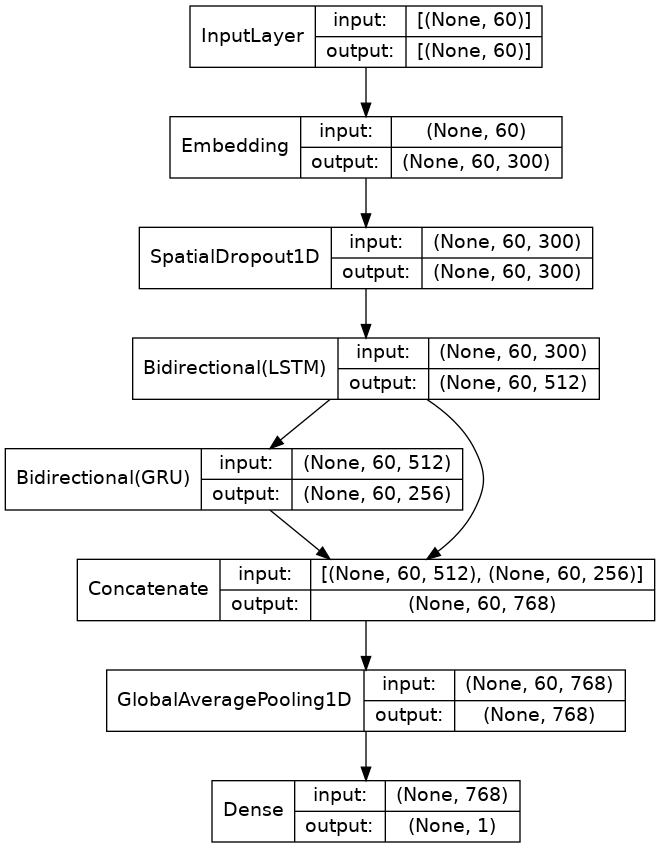

In [15]:
EMBEDDING_DIM = 300
learning_rate = 0.001

def createModel_bidirectional_LSTM_GRU(features,embedding_matrix = None):
    output_bias = Constant(np.log([len(data_pos)/len(data_neg)])) # Khởi tạo gia trị đầu cho bias
    
    x_input = Input(shape=(MAX_SENTENCE_LENGTH))
    if not(embedding_matrix is None):
        embedding = Embedding(features, EMBEDDING_DIM, input_length=MAX_SENTENCE_LENGTH, weights=[embedding_matrix], trainable=False)(x_input)
    else:
        embedding = Embedding(features, EMBEDDING_DIM, input_length=MAX_SENTENCE_LENGTH)(x_input)
    x = SpatialDropout1D(0.5)(embedding)
    
    lstm = Bidirectional(LSTM(256, return_sequences=True))(x)
    gru = Bidirectional(GRU(128, return_sequences=True))(lstm)
    
    x = Concatenate()([lstm, gru])
    x = GlobalAveragePooling1D()(x)
    
    x_output = Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    
    model = Model(inputs=x_input, outputs=x_output)
    opt = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer= opt, metrics=[f1_m])
    return model


# Sử dụng hàm này để tính f1_score trong khi train model
# không biết vì sao e dùng metrics.f1_score lại bị lỗi :(
def f1_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Threshold

Bình thường, đối với phân lớp nhị phân kết quả dự đoán sẽ thuộc (0,1), threshold = 0.5 .

Nếu threshold < 0.5 thì phân lớp là negative, ngược lại thì là positive

Nhưng trong một số trường hợp, giá trị 0.5 này có thể chưa phải là tốt nhất. 

Do đó, ta thử điều chỉnh giá trị threshold này để tìm ra giá trị nào mà cho f1_score là tốt nhất => best_threshold

In [16]:
def best_threshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.9, 0.01)):
        tmp[1] = metrics.f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    return delta, tmp[2] # threshold, f1_score

# 4. Huấn luyện và dự đoán



Tận dụng TPU của kaggle để giảm thời gian huấn luyện.

In [17]:
# khởi tạo strategy sử dụng TPU để train model => tăng tốc độ train
strategy = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


`class_weight`: Nhận thấy tỉ lệ dữ liệu class 0: class 1 = 15:1 (dữ liệu bị lệch), để giảm thiểu ảnh hưởng thì mình sử dụng class_weight để cân bằng trọng số cho hàm mất mát trong khi huấn luyện. 
Sau khi thử nghiệm với nhiều class_weight khác nhau, e thấy chọn tỉ lệ 1:3 mang lại hiệu quả ổn nhất.

**Early Stop Callback:**

Nói một cách ngắn gọn là Early Stop Callback dùng để dừng quá trình train sớm, sau khi mà thông số chúng ta quan sát (có thể là validation accuracy hay validaiton loss) không “khá lên” sau một vài epochs.

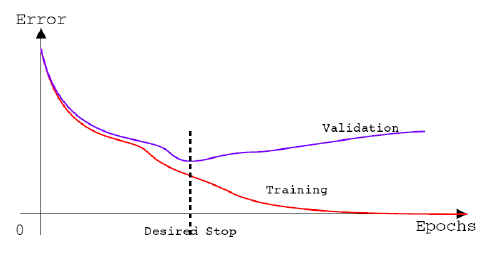

Đây cũng là một kỹ thuật hay được dùng để tránh overfit. Không phải cứ train với nhiều epochs là tốt, chúng ta train nhiều quá mà không thấy val_loss giảm nữa hoặc val_acc tăng nữa mà vẫn tiếp tục train thì sẽ dẫn đến có khả năng overfit.

**Reduce Learning rate:**

Khi bắt đầu training, em sẽ chọn learning rate lớn một xíu để tăng tốc quá trình train. Sau đó sẽ giảm tốc độ học đi nếu sau một số epochs, độ lỗi trên tập validation không giảm

In [18]:
class_weight = {
    0: 1,
    1: 3,
}
batch_size = 1024
n_epochs = 30

early_stopping=tf.keras.callbacks.EarlyStopping(
                                                monitor="val_loss",
                                                patience=3,
                                                mode="min",
                                                restore_best_weights=True
                                              )
### Giảm learning rate khi model không được cải thiên (càng học càng ngu)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
                                                monitor="val_loss",
                                                factor=0.2,
                                                patience=2,
                                                verbose=1,
                                                mode="auto"
                                            )

my_callbacks=[early_stopping,reduce_lr]
def train_model_and_predict(X_train, y_train, X_val, y_val, X_test, embedding_vec=None):
    # tokenize and convert to sequence
    print("Create vocab...")
    tokenizer = create_tokenizer(X_train)
    print("Create sequences...")
    X_train_seq = create_sequence(tokenizer, X_train)
    X_val_seq = create_sequence(tokenizer, X_val)
    X_test_seq = create_sequence(tokenizer, X_test)
    embedding_matrix = None
    if not(embedding_vec is None):
        embedding_matrix = load_embedding(embedding_vec, tokenizer.word_index)
    
    # build model and training
    model = createModel_bidirectional_LSTM_GRU(len(tokenizer.word_index)+1, embedding_matrix)
    model.fit(X_train_seq, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val_seq, y_val), class_weight=class_weight, callbacks=my_callbacks)
    
    # get f1_score, threshold
    val_pred = model.predict(X_val_seq, verbose=1, batch_size=256)
    threshold, f1_score = best_threshold(y_val, val_pred)
    
    test_pred = model.predict(X_test_seq, verbose=1, batch_size=256)
    
    return threshold, f1_score, val_pred, test_pred

# 5. Thử nghiệm và cải thiện

## Train model without Pretrained Embeddings
Thử nghiệm với mô hình với lớp embedding sẽ không sử dụng bất kì pretrain word embeddings nào (mô hình học lại từ đầu)

Khi đó phần trọng số của layer embedding sẽ được khởi tạo ngẫu nhiên, sau đó được cải thiện từ từ trong quá trình huấn luyện

In [19]:
# train
with strategy.scope():
    threshold, f1_score, val_pred, test_pred = train_model_and_predict(X_train, y_train, X_val, y_val, testX_text)
print(metrics.classification_report(y_val,(val_pred>threshold).astype(int)))

Create vocab...
Size of vocabulary:  170512
Create sequences...
Epoch 1/30
1021/1021 [==============================] - 92s 77ms/step - loss: 0.3004 - f1_m: 0.4661 - val_loss: 0.1286 - val_f1_m: 0.6172
Epoch 2/30
1021/1021 [==============================] - 71s 69ms/step - loss: 0.1945 - f1_m: 0.6396 - val_loss: 0.1206 - val_f1_m: 0.6282
Epoch 3/30
1021/1021 [==============================] - 71s 69ms/step - loss: 0.1683 - f1_m: 0.6781 - val_loss: 0.1244 - val_f1_m: 0.6245
Epoch 4/30
1021/1021 [==============================] - 71s 70ms/step - loss: 0.1488 - f1_m: 0.7120 - val_loss: 0.1362 - val_f1_m: 0.6148

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/30
1021/1021 [==============================] - 13s 12ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

1468/1468 [==============================] - 16s 11ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    245143
           1       0.58      0.72      0.65     16082

    accuracy                           0.95    261225
   macro avg       0.78      0.84      0.81    261225
weighted avg       0.96      0.95      0.95    261225



Mô hình đã nhận diện được hầu hết các câu negative.

Tuy nhiên đối với các câu positive thì độ chính xác chưa được cao lắm, đồng thời cũng không thực sự nhạy (recall ~ 0.7). Dẫn đến F1 score chỉ được 0.65

## Train model with Pretrained Embeddings
Thử nghiệm với mô hình kết hợp các word embeddings được pretained

Ta xẽ xem xét các tập trọng số của embedding được trainning sẵn có cải thiện mô hình không.

Phần này ta sẽ thử qua các embedding sau:
- GloVe embedding
- Paragram embedding
- Wiki-news embedding

### Đọc file embeddings

Các file embedding có dạng text, mỗi dòng chứa 1 word và kèm sau đó là 1 vector tương ứng

Ta cần lấy các word có trong từ điển kèm với vecto tương ứng để tạo thành 1 dict để có thể tra cứu nhanh các vecto tương ứng với các từ



In [20]:
# tách từ và vecto tương ứng với nó
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
# lấy số dòng của file embeddings 
def get_lines_count(file_name): 
    return sum(1 for _ in open(file_name, encoding="utf8", errors='ignore'))
# chuyển file embeddigns thành dict
def load_vec(file_name): 
    return dict(
        get_coefs(*o.split(" ")) 
            for o in tqdm(open(
                file_name, encoding="utf8", errors='ignore'), 
                total=get_lines_count(file_name)
            ) if len(o) > 100
    )

Ta cần tạo một mảng chưa weight của các từ tương ứng với `tokenizer.word_index`

Nhận thấy các từ trong từ điển có khả năng không dó trong word embeddings. 

=> Để hiệu quả nhất thì với mỗi từ mà ta không tìm thấy trong word embeddings thì ta sẽ thử biến đổi từ sao cho tìm được vecto gần nó nhất. Bởi vì như vậy chắc chắn sẽ tốt hơn là không có thông tin gì

Để biến đổi từ thì ta sẽ sử dụng một số ký thuật sau:
- Chuyển thành chữ viết hoa
- Chuyển thành chữ thường
- Chuyển thành chữ hoa
- Sử dụng các thư viện để stem từ (cắt đi một phần kí tự ở cuối từ)

Chiến thuật là tìm được càng nhiều từ càng tốt.

In [21]:
EMBEDDING_DIM = 300 # chọn số chiều của vecto embedding là 300

ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')

def load_embedding(word2vec, word2index):
    oov_count = 0 # Số lượng từ không tìm thấy vecto embeddings
    vocab_count = 0 # Số lượng từ có vecto embeddings
    vocab_size = len(word2index)
    
    embedding_weights = np.zeros((vocab_size+1, EMBEDDING_DIM)) # khởi tạo trọng số weight = 0
    unknown_vector = np.zeros((EMBEDDING_DIM,), dtype=np.float32) - 1
    unknown_words = []

    # Tìm kiếm từng từ trong embeddings, nếu không thấy thì lần lượt thực hiện các kỹ thuật biến đổi từ để tìm ra từ gần nghĩa.
    # => hi vọng embeddings cho trước phủ được càng nhiều từ càng tốt.
    for key, i in tqdm(word2index.items()):
        word = key
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue

        word = key.capitalize()       
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
        
        word = key.upper()       
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
        
        word = key.lower()       
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
        
        # PorterStemmer ("python","pythoner","pythoning","pythoned" => "python")
        word = ps.stem(key)        
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
        
        # LancasterStemmer
        word = lc.stem(key)        
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
            
        # SnowballStemmer (connection, connections, connective, connected, and connecting => connect)
        word = sb.stem(key)        
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
            
        unknown_words.append(key)
            
        embedding_weights[i] = unknown_vector

    print('Top 10 Null word embeddings: ')
    print(unknown_words[:10])
#      % np.sum(np.sum(embedding_weights, axis=1) == -1 * EMBEDDING_DIM)
    print('\nNull word embeddings: %d' % len(unknown_words))
    print("There are {:.2f}% word out of embedding file".format(100*len(unknown_words)/vocab_size))
    return embedding_weights

**1. GloVe embeddings**

GloVe là viết tắt của global vectors, một dự án mã nguồn mở của Stanford nhằm tạo ra các véc tơ biểu diễn cho các từ. 

In [22]:
GLOVE_FILE = 'glove.840B.300d/glove.840B.300d.txt'
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {GLOVE_FILE} -d .
print('loading glove_vec')
glove_vec = load_vec(GLOVE_FILE)

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
  inflating: ./glove.840B.300d/glove.840B.300d.txt  
loading glove_vec


  0%|          | 0/2196017 [00:00<?, ?it/s]

In [23]:
with strategy.scope():
    glove_threshold, glove_f1_score, glove_val_pred, glove_test_pred = train_model_and_predict(X_train, y_train, X_val, y_val, testX_text, glove_vec)
print(metrics.classification_report(y_val,(glove_val_pred>glove_threshold).astype(int)))

Create vocab...
Size of vocabulary:  170512
Create sequences...


  0%|          | 0/170512 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
['<OOV>', 'brexit', 'redmi', 'cryptocurrencies', 'oneplus', 'coinbase', 'machedo', 'upwork', 'gdpr', 'adityanath']

Null word embeddings: 32581
There are 19.11% word out of embedding file
Epoch 1/30
1021/1021 [==============================] - 50s 39ms/step - loss: 0.2783 - f1_m: 0.5042 - val_loss: 0.1278 - val_f1_m: 0.6313
Epoch 2/30
1021/1021 [==============================] - 34s 34ms/step - loss: 0.2130 - f1_m: 0.6198 - val_loss: 0.1245 - val_f1_m: 0.6418
Epoch 3/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1997 - f1_m: 0.6347 - val_loss: 0.1240 - val_f1_m: 0.6461
Epoch 4/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1915 - f1_m: 0.6490 - val_loss: 0.1287 - val_f1_m: 0.6442
Epoch 5/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1859 - f1_m: 0.6564 - val_loss: 0.1187 - val_f1_m: 0.6549
Epoch 6/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1774 - f1_m:

  0%|          | 0/80 [00:00<?, ?it/s]

1468/1468 [==============================] - 16s 11ms/step
Glove: Best f1_score = 0.69 at threshold = 0.68
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    245143
           1       0.65      0.74      0.69     16082

    accuracy                           0.96    261225
   macro avg       0.82      0.86      0.83    261225
weighted avg       0.96      0.96      0.96    261225



Sử dụng GloVe embedding đã cải thiện được hiệu quả của model, F1_score tăng rõ rệt (từ 0.65 lên 0.69) so với khi không sử dụng.

Hiệu năng được cải thiện không nằm ngoài dự đoán do việc sử dụng trọng số từ file embedding nó giúp các từ gần nghĩa với nhau sẽ có biểu diễn tương tự nhau => tăng khả năng đọc hiểu của model.


In [24]:
# Xóa để giải phóng bộ nhớ
del glove_vec
gc.collect()

10190

**2. Paragram embeddings**

Tiếp tục thử nghiệm với một embedding khác

In [25]:
PARA_FILE = 'paragram_300_sl999/paragram_300_sl999.txt'
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {PARA_FILE} -d .
print('loading para_vec')
para_vec = load_vec(PARA_FILE)

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
  inflating: ./paragram_300_sl999/paragram_300_sl999.txt  
loading para_vec


  0%|          | 0/1703756 [00:00<?, ?it/s]

In [26]:
with strategy.scope():
    para_threshold, para_f1_score, para_val_pred, para_test_pred = train_model_and_predict(X_train, y_train, X_val, y_val, testX_text, para_vec)
print(metrics.classification_report(y_val,(para_val_pred>para_threshold).astype(int)))

Create vocab...
Size of vocabulary:  170512
Create sequences...


  0%|          | 0/170512 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
['<OOV>', 'brexit', 'redmi', 'cryptocurrencies', 'oneplus', 'coinbase', 'machedo', 'upwork', 'gdpr', 'adityanath']

Null word embeddings: 30322
There are 17.78% word out of embedding file
Epoch 1/30
1021/1021 [==============================] - 50s 39ms/step - loss: 0.2903 - f1_m: 0.4909 - val_loss: 0.1342 - val_f1_m: 0.6142
Epoch 2/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.2172 - f1_m: 0.6120 - val_loss: 0.1367 - val_f1_m: 0.6240
Epoch 3/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.2037 - f1_m: 0.6308 - val_loss: 0.1238 - val_f1_m: 0.6423
Epoch 4/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1949 - f1_m: 0.6457 - val_loss: 0.1326 - val_f1_m: 0.6392
Epoch 5/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1841 - f1_m: 0.6588 - val_loss: 0.1286 - val_f1_m: 0.6455

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/30

  0%|          | 0/80 [00:00<?, ?it/s]

1468/1468 [==============================] - 17s 11ms/step
Paragram: Best f1_score = 0.67 at threshold = 0.64
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    245143
           1       0.63      0.72      0.67     16082

    accuracy                           0.96    261225
   macro avg       0.80      0.85      0.82    261225
weighted avg       0.96      0.96      0.96    261225



Với paragram embedding, ta thấy nó bao phủ được nhiều từ vựng hơn so với GloVe (GloVe ~ 81%, paragram ~ 83%)

Tuy nhiên F1_score lại bị giảm so với GloVe, nhưng vẫn hiệu quả hơn so với khi không sử dụng pretrain.

In [27]:
# Xóa để giải phóng bộ nhớ
del para_vec
gc.collect()

19450

**3. Wiki-news embeddings**

Tiếp tục thử nghiệm với wiki-news

In [28]:
WIKI_FILE = 'wiki-news-300d-1M/wiki-news-300d-1M.vec'
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {WIKI_FILE} -d .
print('loading wiki_vec')
wiki_vec = load_vec(WIKI_FILE)

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
  inflating: ./wiki-news-300d-1M/wiki-news-300d-1M.vec  
loading wiki_vec


  0%|          | 0/999995 [00:00<?, ?it/s]

In [29]:
with strategy.scope():
    wiki_threshold, wiki_f1_score, wiki_val_pred, wiki_test_pred = train_model_and_predict(X_train, y_train, X_val, y_val, testX_text, wiki_vec)
print(metrics.classification_report(y_val,(wiki_val_pred>wiki_threshold).astype(int)))

Create vocab...
Size of vocabulary:  170512
Create sequences...


  0%|          | 0/170512 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
['<OOV>', 'quorans', 'kvpy', 'comedk', 'quoran', 'wbjee', 'fortnite', 'oneplus', 'marksheet', 'uceed']

Null word embeddings: 43503
There are 25.51% word out of embedding file
Epoch 1/30
1021/1021 [==============================] - 49s 39ms/step - loss: 0.2999 - f1_m: 0.4658 - val_loss: 0.1357 - val_f1_m: 0.6101
Epoch 2/30
1021/1021 [==============================] - 37s 37ms/step - loss: 0.2337 - f1_m: 0.5878 - val_loss: 0.1221 - val_f1_m: 0.6338
Epoch 3/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.2175 - f1_m: 0.6110 - val_loss: 0.1228 - val_f1_m: 0.6423
Epoch 4/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.2097 - f1_m: 0.6230 - val_loss: 0.1187 - val_f1_m: 0.6514
Epoch 5/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.2021 - f1_m: 0.6381 - val_loss: 0.1220 - val_f1_m: 0.6530
Epoch 6/30
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1972 - f1_m: 0.6425 - va

  0%|          | 0/80 [00:00<?, ?it/s]

1468/1468 [==============================] - 16s 11ms/step
Wiki-news: Best f1_score = 0.6856 at threshold = 0.62
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    245143
           1       0.65      0.72      0.69     16082

    accuracy                           0.96    261225
   macro avg       0.82      0.85      0.83    261225
weighted avg       0.96      0.96      0.96    261225



 Sử dụng wiki-news embeddings, ta thấy số lượng từ không năm trong file này tăng nhiều hơn so với GloVe, nhưng bất hiệu năng của mô hình vẫn xấp xỉ với GloVe (F1_score ~ 0.69)

In [30]:
# Xóa để giải phóng bộ nhớ
del wiki_vec
gc.collect()

47867

### Stack Models Prediction

Tổng kết lại thì có thể thấy được rằng hiệu năng của model với các ma trận embeddings Glove, Paragram và Wiki-news khá tương đồng với nhau, cả về độ phủ, cả về f1_score và những yếu tố khác.

Tuy nhiên tại sao chúng ta không kết hợp lại các kết quả của từ mô hình bên trên, rồi đưa ra kết quả cuối cùng.

Ta sẽ lấy kết quả trung bình của 3 lần huấn luyện bên trên.

In [37]:
val_prod = np.zeros((len(X_val),), dtype=np.float32)

val_prod += 1/3 * np.squeeze(glove_val_pred)
val_prod += 1/3 * np.squeeze(para_val_pred)
val_prod += 1/3 *np.squeeze(wiki_val_pred)
threshold_global, f1_global = best_threshold(y_val, val_prod)
print(metrics.classification_report(y_val,(val_prod>threshold_global).astype(int)))

  0%|          | 0/80 [00:00<?, ?it/s]

Best f1_score = 0.695 at threshold = 0.58
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    245143
           1       0.63      0.77      0.70     16082

    accuracy                           0.96    261225
   macro avg       0.81      0.87      0.84    261225
weighted avg       0.96      0.96      0.96    261225



Kết quả được cải thiện nhẹ, F1_score tăng lên gần 0.7

# 6. Submit test

In [38]:
pred_prob = np.zeros((len(testX_text),), dtype=np.float32)
pred_prob += 1/3 * np.squeeze(glove_test_pred)
pred_prob += 1/3 * np.squeeze(para_test_pred)
pred_prob += 1/3 * np.squeeze(wiki_test_pred)
y_test_pre=((pred_prob>threshold_global).astype(int))

## Creating the submission File
submit = pd.DataFrame()
submit["qid"]=test_df.qid
submit["prediction"]=y_test_pre
submit.to_csv("submission.csv",index=False)